In [1]:
import sys
sys.path.insert(0, '..\\..\\..\\frxas.py')
import glob
import re

import numpy as np
import h5py
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, minimize, fit_report

from frxas import hdf5_io
from frxas import models
from frxas import visualization
from frxas.models import save_fit_report, load_fit_report

%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [48]:
def chi_patterned(x, amp=1, gammap=1e-3, ld=15, tg=1, f=1, L=0.6):
    r"""1D model of ORR on patterned thin film electrode.

    Parameters
    ----------
    x : list or np.ndarray
        Array or list of arrays of length values.
    amp : float
        Arbitrary scaling factor relating absorbance to concentration
        displacements
    gammap : float
        Ratio of electrolyte to electrode resistances
    ld : float
        :math:`l_{\delta}` : Characteristic length scale of vacancy profile,
        often called the "utilization length".
    tg : float
        :math:`t_G`  : Characteristic time scale of vacancy profile. Reflects
        time scale of switching from kinetic limitations (low frequency) to
        co-limitation by kinetics and diffusion (moderate to high frequency).
    f : float
        Applied linear frequency in units of Hz.
    L : float
        Film thickness in microns.

    Returns
    -------
    np.ndarray
        Evaluated function for given length array and parameters.
    """
    g_p = gammap
    w = 2 * np.pi * f
    chi = -amp /(1 +  g_p * np.sqrt(1 + 1j * tg * w)) \
    * np.exp(-x / ld * np.sqrt(1 + 1j * tg * w))
    # Note gamma_p = gamma * L / ld
    
    return chi

def calc_Roo(Ao, tg, xvo, L):
    co = 3/35.914
    
    return (co * L * xvo) / (4 * Ao * tg)

def calc_Dv(Ao, tg, ld):
    return ld **2 / (Ao * tg)

In [14]:
starts = [[4, 0, 2, 3], [6, 1, 6, 0], [0, 0,2]] # [[0,0,0,0],[0,0,0,0],[0,0,0]]
# f = hdf5_io.get_all_datasets('..\\Model Fitting\July18_frXAS_LV_Analyzed', harmonic=1, start_indices=starts) 
f1 = hdf5_io.get_all_datasets('..\\Model Fitting\\July18_frXAS_Py_Analyzed', harmonic=1, start_indices=starts) 
# f2 = hdf5_io.get_all_datasets('..\\Model Fitting\\July18_frXAS_Py_Analyzed', harmonic=2, start_indices=starts) 
# f3 = hdf5_io.get_all_datasets('..\\Model Fitting\\July18_frXAS_Py_Analyzed', harmonic=3, start_indices=starts) 
# f4 = hdf5_io.get_all_datasets('..\\Model Fitting\\July18_frXAS_Py_Analyzed', harmonic=4, start_indices=starts) 
hdf5_io.close_hdf5('..\\Model Fitting\\July18_frXAS_Py_Analyzed')
hdf5_io.close_hdf5('..\\Model Fitting\July18_frXAS_LV_Analyzed')

In [15]:
# x, data4, frequencies, gases, sizes = hdf5_io.unpack_data(f4, kind='adj')
# x, data3, frequencies, gases, sizes = hdf5_io.unpack_data(f3, kind='adj')
# x, data2, frequencies, gases, sizes = hdf5_io.unpack_data(f2, kind='adj')
x, data1, frequencies, gases, sizes = hdf5_io.unpack_data(f1, kind='adj')
# x0, data0, frequencies0, gases0, sizes0 = hdf5_io.unpack_data(f, kind='adj')

In [16]:
colors = ['k', 'r', 'b', 'c']
markers = [(6, 2, 0), 's', '^', 'o']

colors = colors * (len(colors) % len(data1))
markers = markers * (len(colors) % len(data1))

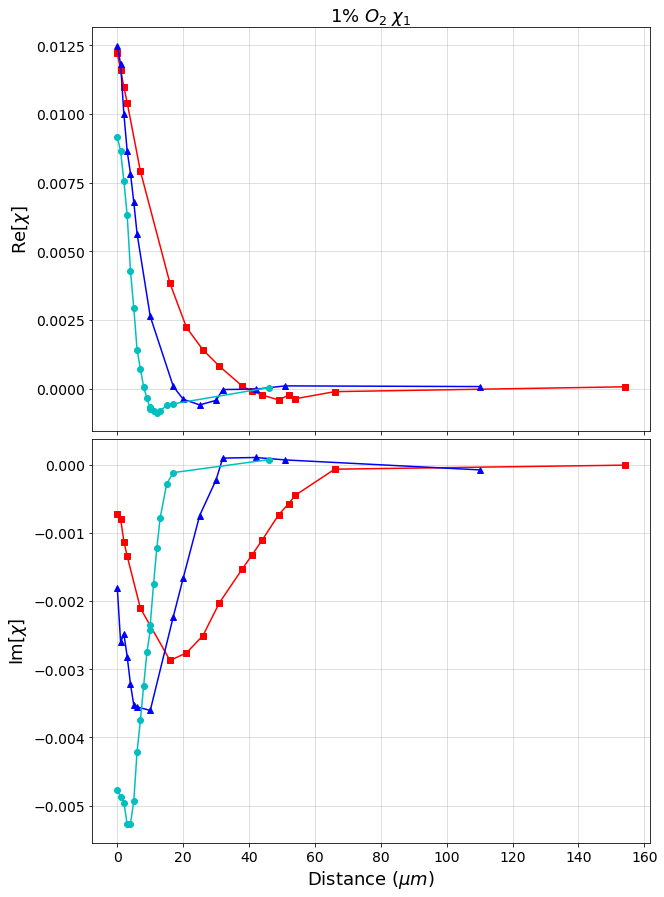

In [17]:
fig, axes = plt.subplots(nrows=2, figsize=(10,15))

for iy in np.arange(1,sizes[0]):
    visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
# for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
#     visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
# for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
#     visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
axes[0].set_title('1% $O_2 \; \chi_1$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Chi2 1%O2.png', dpi=400, bbox_inches='tight')

In [63]:
fit_params = Parameters()

for iy, data in enumerate(data1):
    fit_params.add(f'amp_{iy+1}', value=-data[0].real/.9, min=-1, max=-1e-3)
    fit_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=.2)
    fit_params.add(f'ld_{iy+1}', value=15, min=1e-9, max=100)
    fit_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    fit_params.add(f'f_{iy+1}', value=frequencies[iy], vary=False)
    fit_params.add(f'L_{iy+1}', value=6e-1, vary=False)
    
# Setting other parameters within each dataset to be equal
t_1 = 4
t_10 = 8
t_100 = 11
for iy in np.arange(0, sizes[0]):
    if (iy+1) != t_1:
        fit_params[f'gammap_{iy+1}'].expr = f'gammap_{t_1}'
        fit_params[f'ld_{iy+1}'].expr = f'ld_{t_1}'
        fit_params[f'tg_{iy+1}'].expr = f'tg_{t_1}'

for iy in np.arange(sizes[0], sum(sizes[:2])):
    if (iy+1) != t_10:
        fit_params[f'gammap_{iy+1}'].expr = f'gammap_{t_10}'
        fit_params[f'ld_{iy+1}'].expr = f'ld_{t_10}'
        fit_params[f'tg_{iy+1}'].expr = f'tg_{t_10}'

for iy in np.arange(sum(sizes[:2]), len(data1)):
    if (iy+1) != t_100:
        fit_params[f'gammap_{iy+1}'].expr = f'gammap_{t_100}'
        fit_params[f'ld_{iy+1}'].expr = f'ld_{t_100}'
        fit_params[f'tg_{iy+1}'].expr = f'tg_{t_100}'

In [64]:
for iy in np.arange(1, sizes[0]):
    if (iy+1) != t_1:
        fit_params[f'amp_{iy+1}'].expr = f'amp_{t_1}'

for iy in np.arange(sizes[0]+1, sum(sizes[:2])):
    if (iy+1) != t_10:
        fit_params[f'amp_{iy+1}'].expr = f'amp_{t_10}'

for iy in np.arange(sum(sizes[:2])+1, len(data1)):
    if (iy+1) != t_100:
        fit_params[f'amp_{iy+1}'].expr = f'amp_{t_100}'

In [65]:
mini=lmfit.Minimizer(models.objective_fun, fit_params, fcn_args=(x, data1, models.chi_patterned))

In [66]:
out = mini.minimize(method='leastsq')
# save_fit_report(f'..\\Fit Reports\\LeastSQ_F3_Pinned_Params_AmpDataInit.txt', out, starts)
print('\u03A7_red = ', out.redchi)
print(fit_report(out))

C:\Users\shadd\Anaconda3\envs\UW\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Χ_red =  5.242569751506839e-06
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 187
    # data points      = 1022
    # variables        = 15
    chi-square         = 0.00527927
    reduced chi-square = 5.2426e-06
    Akaike info crit   = -12411.3013
    Bayesian info crit = -12337.3586
[[Variables]]
    amp_1:     -0.08660428 +/- 0.00196861 (2.27%) (init = -0.08497292)
    gammap_1:   0.03447517 +/- 0.02153105 (62.45%) == 'gammap_4'
    ld_1:       38.3781556 +/- 0.51591631 (1.34%) == 'ld_4'
    tg_1:       3.44245094 +/- 0.70099643 (20.36%) == 'tg_4'
    f_1:        0 (fixed)
    L_1:        0.6 (fixed)
    amp_2:     -0.01344332 +/- 0.00105366 (7.84%) == 'amp_4'
    gammap_2:   0.03447517 +/- 0.02153105 (62.45%) == 'gammap_4'
    ld_2:       38.3781556 +/- 0.51591631 (1.34%) == 'ld_4'
    tg_2:       3.44245094 +/- 0.70099643 (20.36%) == 'tg_4'
    f_2:        0.25 (fixed)
    L_2:        0.6 (fixed)
    amp_3:     -0.01344332 +/- 0.00105366 (7.84%) == 'a

C:\Users\shadd\Anaconda3\envs\UW\lib\site-packages\lmfit\printfuncs.py:179: RuntimeWarning: invalid value encountered in long_scalars
  spercent = '({:.2%})'.format(abs(par.stderr/par.value))


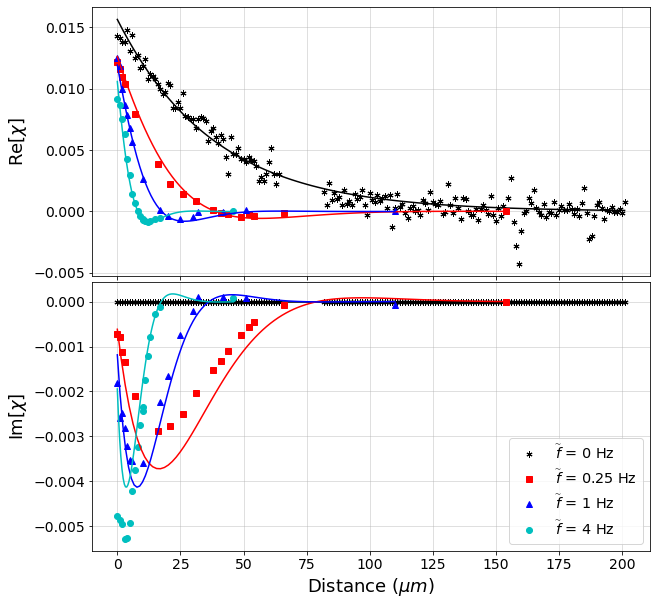

In [22]:
# DC scaling
DC_ind = 0
amp0 = 1
gamma_p0 = out.params[f'gammap_{DC_ind+2}']
ld0 = out.params[f'ld_{DC_ind+2}']
tg0 = out.params[f'tg_{DC_ind+2}']
L0 = out.params[f'L_{DC_ind+2}']
f0 = out.params[f'f_{DC_ind+2}']

# 
scale = np.abs(models.chi_patterned(0, amp0, gamma_p0, ld0, tg0, f0, L0))
norm = -out.params[f'amp_{DC_ind+2}']/(data1[DC_ind][0]*scale)


fig, axes = plt.subplots(nrows=2, figsize=(10,10))
# Plotting steady-state data, scaled down by a normalization factor
visualization.plot_chi(axes, x[DC_ind], data1[DC_ind]*norm, color=colors[0],
                       marker=markers[0], ls='',
                       label='$\widetilde{f}$ = ' + str(frequencies[0]) + ' Hz')
y = np.linspace(0, x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, models.dataset_fun(out.params, DC_ind, y, models.chi_patterned)*norm,
                       color=colors[0], marker='')

for iy in np.arange(1,sizes[0]):
    visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy],
                           marker=markers[iy], ls='',
                           label='$\widetilde{f}$ = ' + str(frequencies[iy]) + ' Hz')
for iy in np.arange(1,sizes[0]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, models.chi_patterned),
                           color=colors[iy], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[1].set_xlabel('y $(\mu m)$')
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_1%O2_parametric_f.png', dpi=400, bbox_inches='tight')

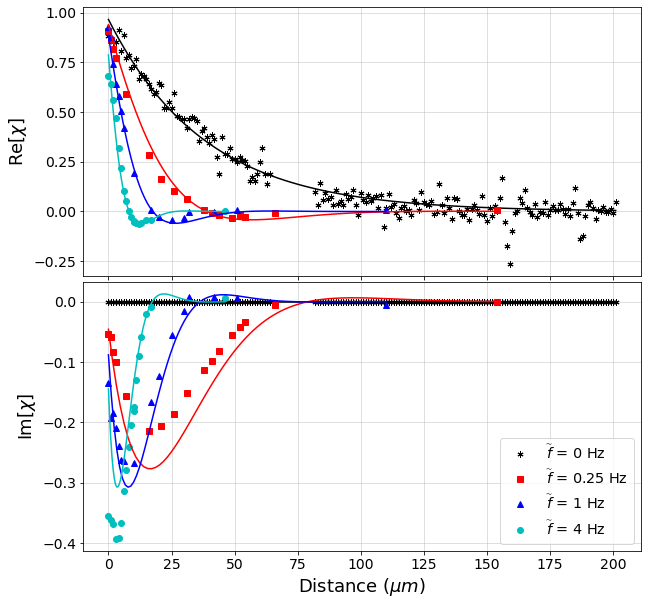

In [67]:
# DC scaling
DC_ind = 0
amp0 = 1
gamma_p0 = out.params[f'gammap_{DC_ind+2}']
ld0 = out.params[f'ld_{DC_ind+2}']
tg0 = out.params[f'tg_{DC_ind+2}']
L0 = out.params[f'L_{DC_ind+2}']
f0 = out.params[f'f_{DC_ind+2}']

# norm = out.params[f'amp_{DC_ind+2}'] / out.params[f'amp_{DC_ind+1}']
norm = -1 / out.params[f'amp_{DC_ind+1}']

fig, axes = plt.subplots(nrows=2, figsize=(10,10))
# Plotting steady-state data, scaled down by a normalization factor
visualization.plot_chi(axes, x[DC_ind], data1[DC_ind]*norm, color=colors[0],
                       marker=markers[0], ls='',
                       label='$\widetilde{f}$ = ' + str(frequencies[0]) + ' Hz')
y = np.linspace(0, x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, models.dataset_fun(out.params, DC_ind, y, models.chi_patterned) * norm,
                       color=colors[0], marker='')

for iy in np.arange(1,sizes[0]):
    visualization.plot_chi(axes, x[iy], data1[iy] / np.abs(out.params[f'amp_{iy+1}']), color=colors[iy],
                           marker=markers[iy], ls='',
                           label='$\widetilde{f}$ = ' + str(frequencies[iy]) + ' Hz')
for iy in np.arange(1,sizes[0]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, models.chi_patterned)/ np.abs(out.params[f'amp_{iy+1}']),
                           color=colors[iy], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[1].set_xlabel('y $(\mu m)$')
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_1%O2_parametric_f.png', dpi=400, bbox_inches='tight')

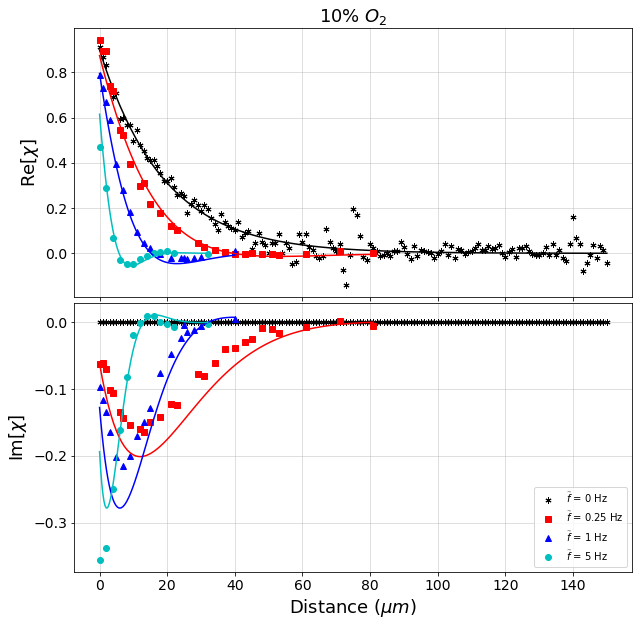

In [68]:
# DC scaling
DC_ind = sizes[0]
amp0 = 1
gamma_p0 = out.params[f'gammap_{DC_ind+2}']
ld0 = out.params[f'ld_{DC_ind+2}']
tg0 = out.params[f'tg_{DC_ind+2}']
L0 = out.params[f'L_{DC_ind+2}']
f0 = out.params[f'f_{DC_ind+2}']


norm = out.params[f'amp_{DC_ind+2}'] / out.params[f'amp_{DC_ind+1}']
norm = -1 / out.params[f'amp_{DC_ind+1}']

fig, axes = plt.subplots(nrows=2, figsize=(10,10))

# Plotting steady-state data, scaled down by a fifth to match other profile amp
visualization.plot_chi(axes, x[DC_ind], data1[DC_ind]*norm, color=colors[0],
                       marker=markers[0], ls='',
                       label='$\widetilde{f}$ = ' + str(frequencies[0]) + ' Hz')
y = np.linspace(0, x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, models.dataset_fun(out.params, DC_ind, y, models.chi_patterned)*norm,
                       color=colors[0], marker='')

for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
    visualization.plot_chi(axes, x[iy], data1[iy] / np.abs(out.params[f'amp_{iy+1}']), color=colors[iy],
                           marker=markers[iy], ls='',
                           label='$\widetilde{f}$ = ' + str(frequencies[iy]) + ' Hz')

for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, models.chi_patterned) / np.abs(out.params[f'amp_{iy+1}']),
                           color=colors[iy], marker='')
                           #label=str(frequencies[iy]) + ' Hz Fit')
    
axes[0].set_title('10% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend()
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern Amp Model wo yd 10%O2.png', dpi=400, bbox_inches='tight')

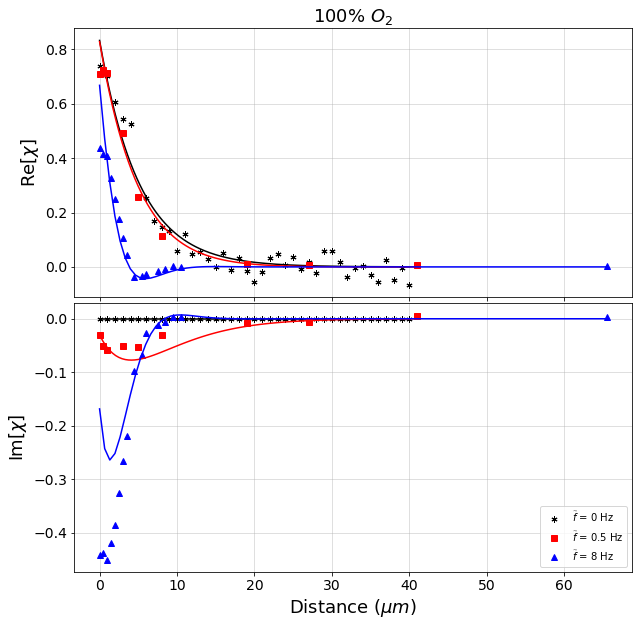

In [69]:
# DC scaling
DC_ind = sum(sizes[:2])
amp0 = 1
gamma_p0 = out.params[f'gammap_{DC_ind+2}']
ld0 = out.params[f'ld_{DC_ind+2}']
tg0 = out.params[f'tg_{DC_ind+2}']
L0 = out.params[f'L_{DC_ind+2}']
f0 = out.params[f'f_{DC_ind+2}']


norm = out.params[f'amp_{DC_ind+2}'] / out.params[f'amp_{DC_ind+1}']
norm = -1 / out.params[f'amp_{DC_ind+1}']
fig, axes = plt.subplots(nrows=2, figsize=(10,10))


# Plotting steady-state data, scaled down by a fifth to match other profile amp
visualization.plot_chi(axes, x[DC_ind], data1[DC_ind]*norm, color=colors[0],
                       marker=markers[0], ls='',
                       label='$\widetilde{f}$ = ' + str(frequencies[0]) + ' Hz')
y = np.linspace(0, x[DC_ind][-1], num=300)
visualization.plot_chi(axes, y, models.dataset_fun(out.params, DC_ind, y, models.chi_patterned)*norm,
                       color=colors[0], marker='')


for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
    visualization.plot_chi(axes, x[iy], data1[iy] / np.abs(out.params[f'amp_{iy+1}']), color=colors[iy],
                           marker=markers[iy], ls='', 
                           label='$\widetilde{f}$ = ' + str(frequencies[iy]) + ' Hz')
for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, models.chi_patterned) / np.abs(out.params[f'amp_{iy+1}']),
                           color=colors[iy], marker='')
                           #label=str(frequencies[iy]) + ' Hz Fit')
    
axes[0].set_title('100% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend()
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern Amp Model wo yd 100%O2.png', dpi=400, bbox_inches='tight')

In [ ]:
models.chi_patterned(0, amp=1, gammap=0, ld=1, tg = )

## Plotting highest freq line parametric in po2

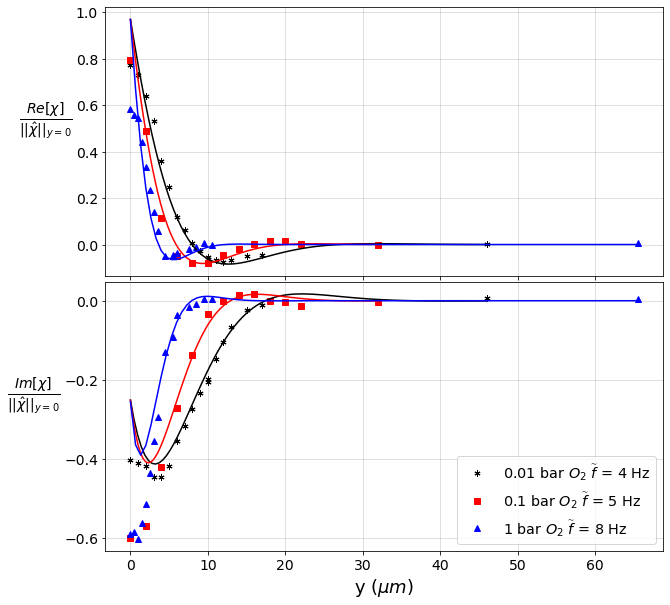

In [34]:

fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for j, iy in enumerate([3, 7, 10]):
    visualization.plot_chi(axes, x[iy], data1[iy]/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)), color=colors[j],
                           marker=markers[j], ls='',
                           label=f'{gases[iy]} bar $O_2$ ' + '$\widetilde{f}$ = ' + f'{frequencies[iy]} Hz')
for j, iy in enumerate([3, 7, 10]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, chi_pattern)/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)),
                           color=colors[j], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[0].set_ylabel('Re[$\chi$] / ||$\hat{\chi}||_{y=0}$')
# axes[1].set_ylabel('Im[$\chi$] / ||$\hat{\chi}||_{y=0}$')
axes[0].set_ylabel(r'$\frac{Re[\chi]}{||\hat{\chi}||_{y=0}}$', rotation=0, labelpad=30, fontsize=20)
axes[1].set_ylabel(r'$\frac{Im[\chi]}{||\hat{\chi}||_{y=0}}$', rotation=0, labelpad=30, fontsize=20)
axes[1].set_xlabel('y $(\mu m)$')

fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_high_f_parametric_pO2.png', dpi=400, bbox_inches='tight')

## Plotting Magnitude of highest freq line parametric in po2

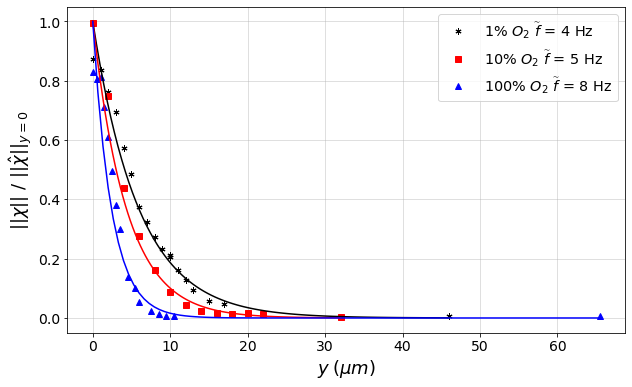

In [82]:
fig, ax = plt.subplots(figsize=(10,6))

for j, iy in enumerate([3, 7, 10]):
    visualization.plot_chi_mag(ax, x[iy], np.abs(data1[iy])/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)), color=colors[j],
                           marker=markers[j], ls='',
                           label=f'{gases[iy]*100:.0f}% $O_2$ ' + '$\widetilde{f}$ = ' + f'{frequencies[iy]} Hz')
for j, iy in enumerate([3, 7, 10]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi_mag(ax, y, np.abs(models.dataset_fun(out.params, iy, y, chi_pattern)/models.dataset_fun(out.params, iy, 0, chi_pattern)),
                           color=colors[j], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[0].set_title('1% $O_2$', fontsize=18)
ax.set_ylabel('||$\chi$|| / ||$\hat{\chi}||_{y=0}$')
# ax.set_ylabel(r'$\frac{||\chi||}{||\hat{\chi}||_{y=0}}$', rotation=0, labelpad=30, fontsize=20)
ax.set_xlabel(r'$y \: (\mu m)$')

fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_Xmag_vs_y_parametric_f.png', dpi=400, bbox_inches='tight')

## Plotting Magnitude of highest freq line vs y*sqrt(f) parametric in po2

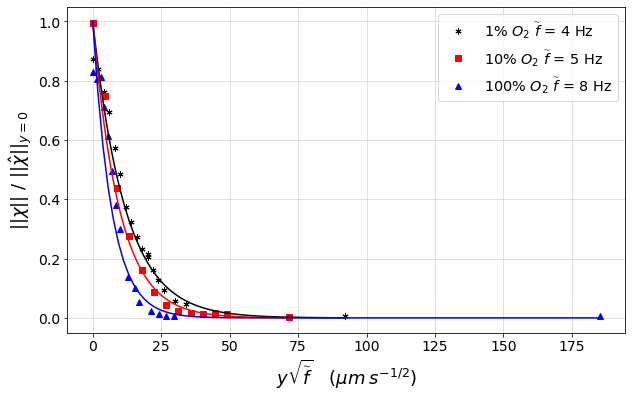

In [84]:
fig, ax = plt.subplots(figsize=(10,6))

for j, iy in enumerate([3, 7, 10]):
    visualization.plot_chi_mag(ax, x[iy]*np.sqrt(frequencies[iy]), np.abs(data1[iy])/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)), color=colors[j],
                           marker=markers[j], ls='',
                           label=f'{gases[iy]*100:.0f}% $O_2$ ' + '$\widetilde{f}$ = ' + f'{frequencies[iy]} Hz')
for j, iy in enumerate([3, 7, 10]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi_mag(ax, y*np.sqrt(frequencies[iy]), np.abs(models.dataset_fun(out.params, iy, y, chi_pattern)/models.dataset_fun(out.params, iy, 0, chi_pattern)),
                           color=colors[j], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[0].set_title('1% $O_2$', fontsize=18)
ax.set_ylabel('||$\chi$|| / ||$\hat{\chi}||_{y=0}$')
# ax.set_ylabel(r'$\frac{||\chi||}{||\hat{\chi}||_{y=0}}$', rotation=0, labelpad=30, fontsize=20)
ax.set_xlabel(r'$y\sqrt{\widetilde{f}} \quad (\mu m \: s^{-1/2})$')

fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_Xmag_vs_yf_parametric_f.png', dpi=400, bbox_inches='tight')

## Plotting Magnitude of highest freq line vs y*sqrt(f) parametric in po2

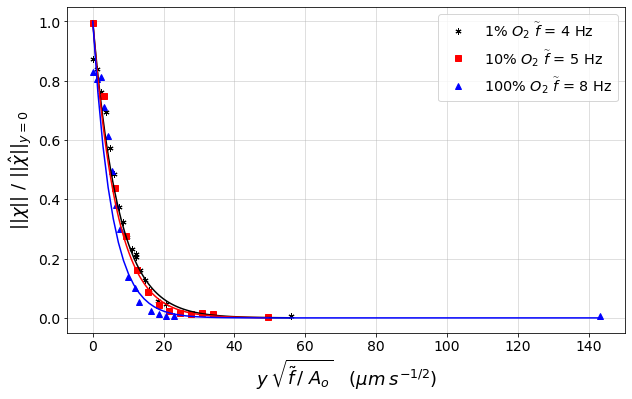

In [87]:
fig, ax = plt.subplots(figsize=(10,6))
Aos = [2.689, 2.088, 1.673]

for j, iy in enumerate([3, 7, 10]):
    visualization.plot_chi_mag(ax, x[iy]*np.sqrt(frequencies[iy]/Aos[j]), np.abs(data1[iy])/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)), color=colors[j],
                           marker=markers[j], ls='',
                           label=f'{gases[iy]*100:.0f}% $O_2$ ' + '$\widetilde{f}$ = ' + f'{frequencies[iy]} Hz')
for j, iy in enumerate([3, 7, 10]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi_mag(ax, y*np.sqrt(frequencies[iy]/Aos[j]), np.abs(models.dataset_fun(out.params, iy, y, chi_pattern)/models.dataset_fun(out.params, iy, 0, chi_pattern)),
                           color=colors[j], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[0].set_title('1% $O_2$', fontsize=18)
# ax.set_ylabel(r'$\frac{||\chi||}{||\hat{\chi}||_{y=0}}$', rotation=0, labelpad=30, fontsize=20)
ax.set_ylabel('||$\chi$|| / ||$\hat{\chi}||_{y=0}$')
ax.set_xlabel(r'$y\, \sqrt{\tilde{f}\, / \,{ \, A_o}} \quad (\mu m \: s^{-1/2})$')

fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_Xmag_vs_yfAo_parametric_f.png', dpi=400, bbox_inches='tight')

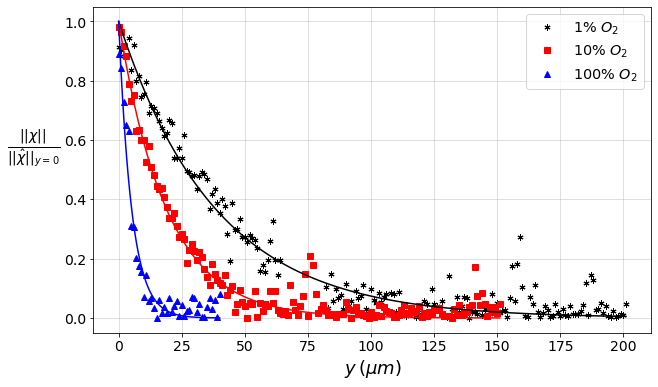

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
Aos = [2.689, 2.088, 1.673]

for j, iy in enumerate([0, 4, 8]):
    visualization.plot_chi_mag(ax, x[iy], np.abs(data1[iy])/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)), color=colors[j],
                           marker=markers[j], ls='',
                           label=f'{gases[iy]*100:.0f}% $O_2$ ')
for j, iy in enumerate([0, 4, 8]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi_mag(ax, y, np.abs(models.dataset_fun(out.params, iy, y, chi_pattern)/models.dataset_fun(out.params, iy, 0, chi_pattern)),
                           color=colors[j], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[0].set_title('1% $O_2$', fontsize=18)
ax.set_ylabel(r'$\frac{||\chi||}{||\hat{\chi}||_{y=0}}$', rotation=0, labelpad=30, fontsize=20)
# ax.set_ylabel('||$\chi$|| / ||$\hat{\chi}||_{y=0}$')
ax.set_xlabel(r'$y \, (\mu m)$')

fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_Xmag_f0_vs_y_parametric_pO2.png', dpi=400, bbox_inches='tight')

## Steady state vs y

0 1.68e-06 0.02008
1 1.464e-06 0.0131
2 1.095e-06 0.007533


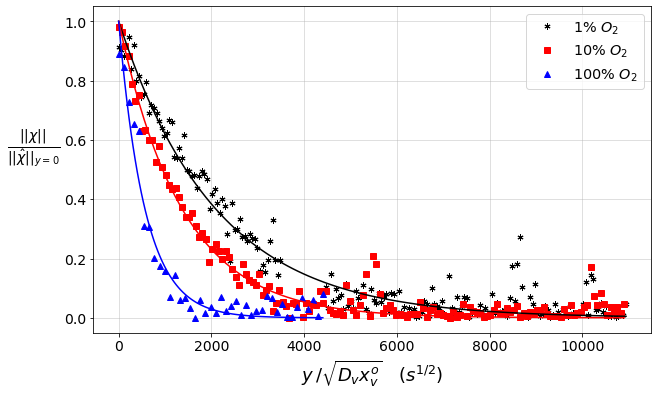

In [102]:
fig, ax = plt.subplots(figsize=(10,6))
Dvs = [1.68e-6, 1.464e-6, 1.095e-6]
xvos = [0.02008, 0.01310, 0.007533]

for j, iy in enumerate([0, 4, 8]):
    print(j, Dvs[j], xvos[j])
    visualization.plot_chi_mag(ax, x[iy]/np.sqrt(Dvs[j]*1e4*xvos[j]), np.abs(data1[iy])/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)), color=colors[j],
                           marker=markers[j], ls='',
                           label=f'{gases[iy]*100:.0f}% $O_2$ ')
for j, iy in enumerate([0, 4, 8]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi_mag(ax, y/np.sqrt(Dvs[j]*1e4*xvos[j]), np.abs(models.dataset_fun(out.params, iy, y, chi_pattern)/models.dataset_fun(out.params, iy, 0, chi_pattern)),
                           color=colors[j], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[0].set_title('1% $O_2$', fontsize=18)
ax.set_ylabel(r'$\frac{||\chi||}{||\hat{\chi}||_{y=0}}$', rotation=0, labelpad=30, fontsize=20)
# ax.set_ylabel('||$\chi$|| / ||$\hat{\chi}||_{y=0}$')
ax.set_xlabel(r'$y\, / \sqrt{D_v x^o_v} \quad (s^{1/2})$')

fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_Xmag_f0_vs_yDvxv_parametric_pO2.png', dpi=400, bbox_inches='tight')

In [101]:
for j, iy in enumerate([0, 4, 8]):
    tg = out.params[f'tg_{iy+1}'].value
    ld = out.params[f'ld_{iy+1}'].value *1e-4
    xvo = xvos[j]
    Ao = Aos[j]
    print(f'Ao: {Ao} tg: {tg} ld: {ld*1e4} xvo: {xvo}')
    print(f'Dv: {calc_Dv(Ao, tg, ld)} Roo: {calc_Roo(Ao, tg, xvo, 630e-7)} \n')

Ao: 2.689 tg: 3.261103510552789 ld: 38.37923860323772 xvo: 0.02008
Dv: 1.6797216622792594e-06 Roo: 3.0126338868201956e-09 

Ao: 2.088 tg: 1.169715942358389 ld: 18.913225277517647 xvo: 0.0131
Dv: 1.4646042419251228e-06 Roo: 7.056647550213476e-09 

Ao: 1.673 tg: 0.15867040451173617 ld: 5.136780215429462 xvo: 0.007533
Dv: 9.940085008142314e-07 Roo: 3.733482603873752e-08 



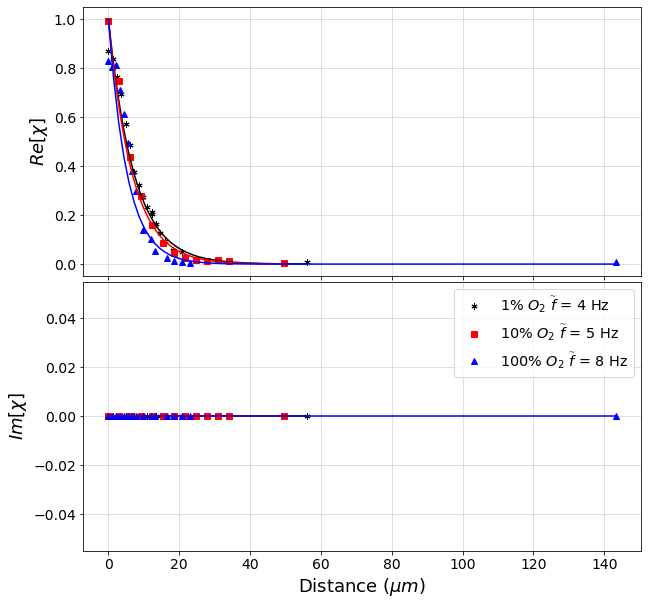

In [20]:
# Plotting highest freq line parametric in po2
fig, axes = plt.subplots(nrows=2, figsize=(10,10))
Aos = [2.689, 2.088, 1.673]
for j, iy in enumerate([3, 7, 10]):
    visualization.plot_chi(axes, x[iy]*np.sqrt(frequencies[iy]/Aos[j]), np.abs(data1[iy])/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)), color=colors[j],
                           marker=markers[j], ls='',
                           label=f'{gases[iy]*100:.0f}% $O_2$ ' + '$\widetilde{f}$ = ' + f'{frequencies[iy]} Hz')
for j, iy in enumerate([3, 7, 10]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y*np.sqrt(frequencies[iy]/Aos[j]), np.abs(models.dataset_fun(out.params, iy, y, chi_pattern)/models.dataset_fun(out.params, iy, 0, chi_pattern)),
                           color=colors[j], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_1%O2_parametric_f.png', dpi=400, bbox_inches='tight')

In [8]:
# Including surface diffusion model

In [9]:
def chi_surf_diff(x, amp=1, gammap=1e-3, ld=15, tg=1, nu=1e-3, f=1, L=0.6):

    g_p = gammap
    w = 2 * np.pi * f
    numer = -amp * np.sqrt(1+ 2 * nu) * np.exp(-(x/ ld)*np.sqrt(1 + 1j * tg * w)/np.sqrt(1 + 2 * nu))
    denom = (np.sqrt(1 + 2 * nu) + g_p * np.sqrt(1 + 1j * tg * w) * (1 - 2 * nu))
#     chi = - amp * np.sqrt(1+2*nu)*np.exp(-(x+yd)/ld*(np.sqrt(1+1j*w*tg)/np.sqrt(1+2*nu)))/(np.sqrt(1+2*nu)+g_p*np.sqrt(1+1j*w*tg)-2*g_p*nu*np.sqrt(1+1j*w*tg))
    chi = numer / denom
    # Note gamma_p = gamma * L / ld
    return chi

In [10]:
fit_params2 = Parameters()

for iy, data in enumerate(data1):
    fit_params2.add(f'amp_{iy+1}', value=-data[0].real/.9, min=-1, max=-1e-3)
    fit_params2.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=1)
    fit_params2.add(f'ld_{iy+1}', value=15, min=1e-9, max=100)
    fit_params2.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    fit_params2.add(f'nu_{iy+1}', value=1e-4, min=0, max=10)
    fit_params2.add(f'f_{iy+1}', value=frequencies[iy], vary=False)
    fit_params2.add(f'L_{iy+1}', value=6e-1, vary=False)

# Setting other parameters within each dataset to be equal
t_1 = 4
t_10 = 8
t_100 = 11
for iy in np.arange(0, sizes[0]):
    if (iy+1) != t_1:
        fit_params2[f'gammap_{iy+1}'].expr = f'gammap_{t_1}'
        fit_params2[f'ld_{iy+1}'].expr = f'ld_{t_1}'
        fit_params2[f'tg_{iy+1}'].expr = f'tg_{t_1}'
        fit_params2[f'nu_{iy+1}'].expr = f'nu_{t_1}'

for iy in np.arange(sizes[0], sum(sizes[:2])):
    if (iy+1) != t_10:
        fit_params2[f'gammap_{iy+1}'].expr = f'gammap_{t_10}'
        fit_params2[f'ld_{iy+1}'].expr = f'ld_{t_10}'
        fit_params2[f'tg_{iy+1}'].expr = f'tg_{t_10}'
        fit_params2[f'nu_{iy+1}'].expr = f'nu_{t_10}'

for iy in np.arange(sum(sizes[:2]), len(data1)):
    if (iy+1) != t_100:
        fit_params2[f'gammap_{iy+1}'].expr = f'gammap_{t_100}'
        fit_params2[f'ld_{iy+1}'].expr = f'ld_{t_100}'
        fit_params2[f'tg_{iy+1}'].expr = f'tg_{t_100}'
        fit_params2[f'nu_{iy+1}'].expr = f'nu_{t_100}'

In [11]:
mini2=lmfit.Minimizer(models.objective_fun, fit_params2, fcn_args=(x, data1, chi_surf_diff))

In [12]:
out2 = mini2.minimize(method='leastsq')
# Saving report fit to a text file
# save_fit_report(f'..\\Fit Reports\\LeastSQ_F3_Pinned_Params_AmpDataInit.txt', out, starts)
print('\u03A7_red = ', out2.redchi)
print(fit_report(out2))

C:\Users\shadd\Anaconda3\envs\UW\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
..\..\..\frxas.py\frxas\models.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  resid = np.array(resid)


Χ_red =  5.2901992957333335e-06
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2446
    # data points      = 1024
    # variables        = 23
    chi-square         = 0.00529549
    reduced chi-square = 5.2902e-06
    Akaike info crit   = -12418.5086
    Bayesian info crit = -12305.0847
[[Variables]]
    amp_1:     -0.08371233 +/- 0.00142565 (1.70%) (init = -0.08497292)
    gammap_1:   1.1231e-09 +/- 0.01105372 (984208675.01%) == 'gammap_4'
    ld_1:       16.1668441 +/- 5227999.51 (32337786.38%) == 'ld_4'
    tg_1:       4.22287708 +/- 0.86129570 (20.40%) == 'tg_4'
    nu_1:       2.31849909 +/- 1822880.46 (78623298.24%) == 'nu_4'
    f_1:        0 (fixed)
    L_1:        0.6 (fixed)
    amp_2:     -0.01198918 +/- 0.00113423 (9.46%) (init = -0.01356824)
    gammap_2:   1.1231e-09 +/- 0.01105372 (984208675.01%) == 'gammap_4'
    ld_2:       16.1668441 +/- 5227999.51 (32337786.38%) == 'ld_4'
    tg_2:       4.22287708 +/- 0.86129570 (20.40%) == 'tg_4'
    n

C:\Users\shadd\Anaconda3\envs\UW\lib\site-packages\lmfit\printfuncs.py:179: RuntimeWarning: invalid value encountered in long_scalars
  spercent = '({:.2%})'.format(abs(par.stderr/par.value))
